In [27]:
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
import pickle

DICT_PATH_TRAIN = os.path.join(PROJ_DIR, 'data', 'cmnist_train_dict.pickle')
DICT_PATH_TEST = os.path.join(PROJ_DIR, 'data', 'cmnist_test_dict.pickle')

In [6]:
data[0].keys()

dict_keys(['id', 'x', 'y', 's_box', 's_digit', 's_area'])

In [35]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_TEST = 256

class CMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dict_file_path:str):
        with open(os.path.join(PROJ_DIR, 'data', 'cmnist_train_dict.pickle'), 'rb') as fIn:
            self.data = pickle.load(fIn)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]['x'], self.data[idx]['y']
    
train_set = CMNISTDataset(dict_file_path=DICT_PATH_TRAIN)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=4)

test_set = CMNISTDataset(dict_file_path=DICT_PATH_TEST)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=4)

Using cuda:0


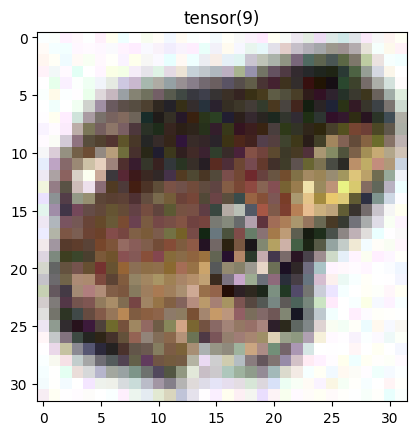

In [26]:
from matplotlib import pyplot as plt
import numpy as np
SAMPLE_NUM = 16

x_batch, y_batch = next(iter(train_loader))

plt.imshow(np.moveaxis(x_batch[SAMPLE_NUM].numpy(), 0, -1))
plt.title(y_batch[SAMPLE_NUM])
plt.show()

In [55]:
import torchvision

# Load the pre-trained ResNet18 model.
model = torchvision.models.resnet18(weights='DEFAULT')

# Freeze all the pre-trained layers.
for param in model.parameters():
    param.requires_grad = True

# Modify the last layer for MNIST
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [56]:
MODEL_EPOCHS= 2
MODEL_LR = 1.0e-2
MOMENTUM = 0.9

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=MODEL_LR, momentum=MOMENTUM)
optimizer = torch.optim.Adam(model.parameters(), lr=MODEL_LR)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=MODEL_LR)

x_test_batch, y_test_batch = next(iter(test_loader))
num_train_batches = len(train_set) // BATCH_SIZE_TRAIN +  1 if len(train_set) % BATCH_SIZE_TRAIN > 0 else 0

for epoch in range(MODEL_EPOCHS):
    batch_num = 0
    for x_batch, y_batch in train_loader:
        batch_num += 1
        optimizer.zero_grad()
        
        preds = model(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()        
        optimizer.step()
        print(f'Batch num:{batch_num}/{num_train_batches}\tLoss:{loss_value.item():.4f}\r')

    test_preds = model.forward(x_test_batch)        
    accuracy = (test_preds.argmax(dim=1) == y_test_batch).float().mean() 
    print(f'Epoch {epoch}/{MODEL_EPOCHS} - Loss: {loss_value.item()} - Test accuracy: {accuracy}')  
    
model.eval()

test_hits = 0
for x_batch, y_batch in test_loader:
    test_preds = model.forward(x_batch)        
    test_hits += (test_preds.argmax(dim=1) == y_batch).float().sum()
print(test_hits / len(test_set))

Batch num:1/235	Loss:2.6263
Batch num:2/235	Loss:25.1076
Batch num:3/235	Loss:23.1554
Batch num:4/235	Loss:27.4883
Batch num:5/235	Loss:18.0134
Batch num:6/235	Loss:14.3099
Batch num:7/235	Loss:11.4375
Batch num:8/235	Loss:6.6901
Batch num:9/235	Loss:6.2084
Batch num:10/235	Loss:4.0386
Batch num:11/235	Loss:8.1189
Batch num:12/235	Loss:5.9070
Batch num:13/235	Loss:5.6278
Batch num:14/235	Loss:5.4418
Batch num:15/235	Loss:4.2891
Batch num:16/235	Loss:4.1592
Batch num:17/235	Loss:3.9144
Batch num:18/235	Loss:4.8787
Batch num:19/235	Loss:5.4575
Batch num:20/235	Loss:4.9076
Batch num:21/235	Loss:3.9220
Batch num:22/235	Loss:2.8573
Batch num:23/235	Loss:5.3998
Batch num:24/235	Loss:5.6732
Batch num:25/235	Loss:3.6862
Batch num:26/235	Loss:3.5768
Batch num:27/235	Loss:2.6629
Batch num:28/235	Loss:2.7807
Batch num:29/235	Loss:3.0094
Batch num:30/235	Loss:2.6552
Batch num:31/235	Loss:2.9682
Batch num:32/235	Loss:2.7273
Batch num:33/235	Loss:2.7877
Batch num:34/235	Loss:2.3488
Batch num:35/235	

KeyboardInterrupt: 

In [37]:
# Save model
torch.save(model.state_dict(), os.path.join(PROJ_DIR,'assets','models','cmnist-resnet18.pth'))

import json
MODELS_PATH = os.path.join(PROJ_DIR,'assets','models')
with open(os.path.join(MODELS_PATH, 'model-accuracies.json')) as fIn:
    models = json.load(fIn)
models['cmnist-resnet18'] = accuracy.item()
with open(os.path.join(MODELS_PATH, 'model-accuracies.json'), 'w') as fOut:
    json.dump(models, fOut)